In [1]:
import pandas as pd
from scipy.io import mmread
import os
import numpy as np
import torchmetrics
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import zarr
import os
import torch
import anndata

from load_data_for_analysis import *
from analysis_utils import *


save_fig = "/data/mikulik/PolarbearPlus/notebooks/figures/"
data_dir = "/data/mikulik/PolarbearPlus/notebooks/data/"


In [3]:
snareseq_barcodes, snareseq_peaks, gene_names = load_snare_data(os.path.join(data_dir, "snareseq"))
true_split = get_test_split_index(os.path.join(data_dir, "split"))
test_cell_names = get_celltype_annotations(os.path.join(data_dir, "diffexp"), snareseq_barcodes=snareseq_barcodes, true_split=true_split)

diff_genes = load_diff_genes(os.path.join(data_dir, "diffexp"))
diff_genes_ind = get_diff_gene_ind(gene_names, diff_genes)

rna_counts, obs_rna = get_rna_counts(os.path.join(data_dir,"snareseq/"), true_split)
atac_counts, obs_atac = get_atac_counts(os.path.join(data_dir,"snareseq/"), true_split)

diff_peaks_ind = get_diff_peaks_ind(os.path.join(data_dir, "diffexp"), snareseq_peaks)

# Compute Correlations

### Load saved predictions

In [4]:
data_dir = "/data/mikulik/mnt_polarbear_exp/"

# Confidence Intervals

In [6]:
plot_df = {}

#### RNA

/data/mikulik/PolarbearPlus/notebooks/analysis_utils.py:186: RuntimeWarning: divide by zero encountered in divide
  obs_scale = (counts[condition] - q025[condition]) / (q975[condition] - q025[condition])


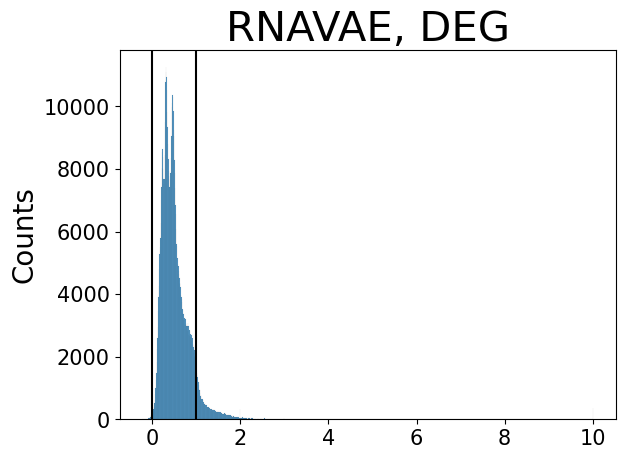

In [8]:
q025, q975 = read_vae_quantiles(data_dir="/data/mikulik/mnt_polarbear_exp/", vae="rnavae")
obs_scale = scale_quantiles(obs_rna[:, diff_genes_ind], 
                            q025[:, diff_genes_ind], 
                            q975[:, diff_genes_ind])
plot_ci(np.clip(obs_scale.reshape(-1),-1, 10), title="RNAVAE, DEG")
plot_df["RNAVAE"] = np.clip(obs_scale.reshape(-1),-1, 10).tolist()
#print(f"Percentage of predictions that are bigger than 1, {file}:{(obs_scale > 1).sum() / obs_scale.shape[0]}")
#print(f"Percentage of predictions that are smaller than 0, {file}: {(obs_scale < 0).sum() / obs_scale.shape[0]}")

#### MLP and INN

In [9]:
# normalize counts
obs_norm = obs_rna / obs_rna.sum(axis=1, keepdims=True)
clips = {"mlptranslator": [100, 5000],
         "inntranslator": [50, 50, 50]}

outputs = "/data/mikulik/mnt_polarbear_exp/" 
subdirs = ["mlptranslator", "inntranslator"]
for subdir in subdirs: 
    for file, clip in zip([i for i in os.listdir(os.path.join(outputs, subdir)) if "atac2rna" in i], 
                          clips[subdir]):
        q025, q975 = read_translator_quantiles(outputs, subdir, file)
        obs_scale = scale_quantiles(obs_norm[:, diff_genes_ind], 
                                    q025[:, diff_genes_ind], 
                                    q975[:, diff_genes_ind])
        #plot_ci(obs_scale[obs_scale < clip], title=f"{subdir}, {file}, DEG")
        plot_df[file] = obs_scale[obs_scale < clip].tolist() #np.clip(obs_scale.reshape(-1),-1, clip)
        print(f"Percentage of predictions that are bigger than 1, {file}:{(obs_scale > 1).sum() / obs_scale.shape[0]}")
        print(f"Percentage of predictions that are smaller than 0, {file}: {(obs_scale < 0).sum() / obs_scale.shape[0]}")

Percentage of predictions that are bigger than 1, settings_polarbear_atac2rna:0.7753006764744015
Percentage of predictions that are smaller than 0, settings_polarbear_atac2rna: 0.15105284431936913
Percentage of predictions that are bigger than 1, settings_sane_atac2rna:0.8142067250859892
Percentage of predictions that are smaller than 0, settings_sane_atac2rna: 0.1828097711274319
Percentage of predictions that are bigger than 1, doublesample_atac2rna_v1:0.6787577886074694
Percentage of predictions that are smaller than 0, doublesample_atac2rna_v1: 0.07891184478458828
Percentage of predictions that are bigger than 1, latent_atac2rna_v1:0.6865170338847324
Percentage of predictions that are smaller than 0, latent_atac2rna_v1: 0.08221871401224823
Percentage of predictions that are bigger than 1, sample_atac2rna_v1:0.6786311879866688
Percentage of predictions that are smaller than 0, sample_atac2rna_v1: 0.07864033983877487


Percentage of predictions that are bigger than 1, RNAVAE:0.07088414517888057
Percentage of predictions that are smaller than 0, RNAVAE: 0.0011531333653648156


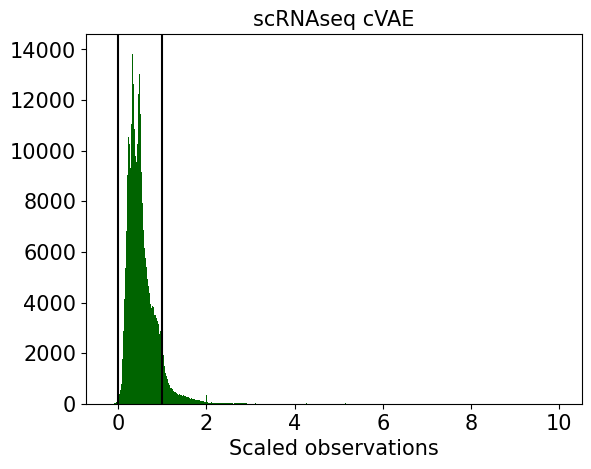

Percentage of predictions that are bigger than 1, settings_polarbear_atac2rna:0.7729249968400576
Percentage of predictions that are smaller than 0, settings_polarbear_atac2rna: 0.15264988146362365


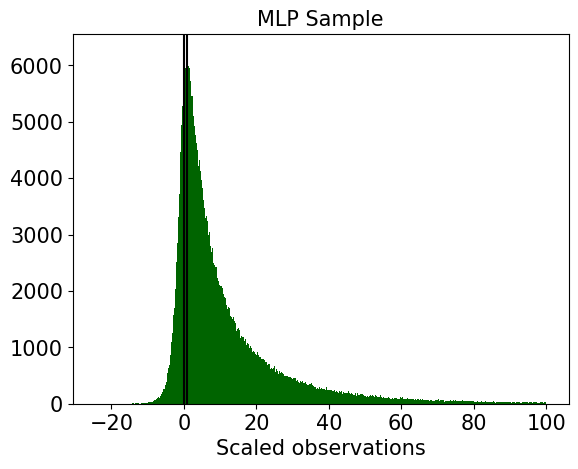

Percentage of predictions that are bigger than 1, settings_sane_atac2rna:0.813421256194043
Percentage of predictions that are smaller than 0, settings_sane_atac2rna: 0.18358262681034548


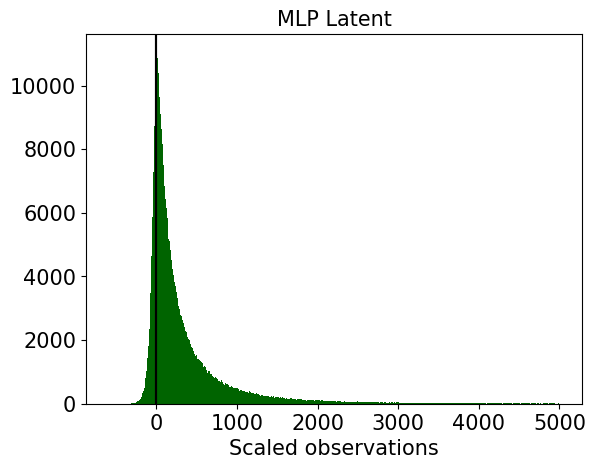

Percentage of predictions that are bigger than 1, doublesample_atac2rna_v1:0.6779876367850749
Percentage of predictions that are smaller than 0, doublesample_atac2rna_v1: 0.07910102945246217


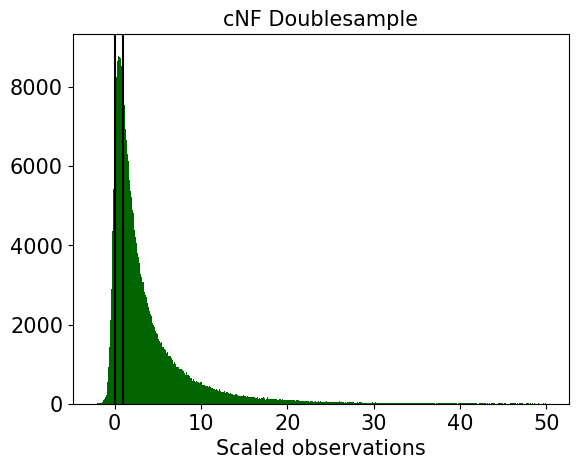

Percentage of predictions that are bigger than 1, latent_atac2rna_v1:0.6857010902228619
Percentage of predictions that are smaller than 0, latent_atac2rna_v1: 0.0824327155556711


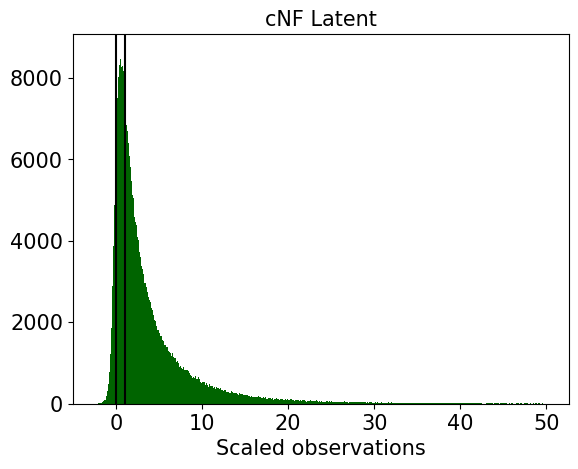

Percentage of predictions that are bigger than 1, sample_atac2rna_v1:0.677876493152863
Percentage of predictions that are smaller than 0, sample_atac2rna_v1: 0.07882501693246431


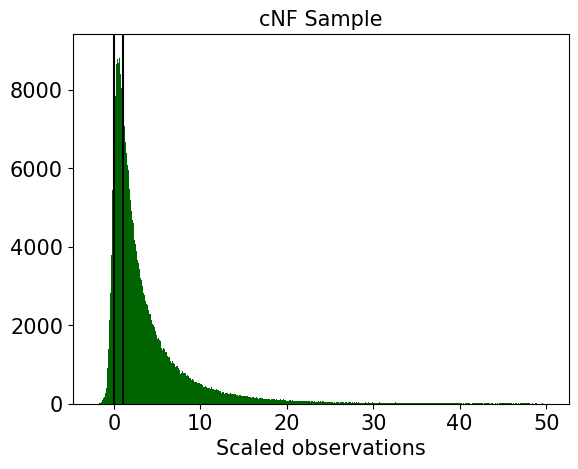

In [37]:
model_names = ["scRNAseq cVAE", "MLP Sample", "MLP Latent", 
               "cNF Doublesample", "cNF Latent", "cNF Sample"]
for i, name in enumerate(plot_df.keys()):
    obs_scale = np.asarray(plot_df[name])
    print(f"Percentage of predictions that are bigger than 1, {name}:{(obs_scale > 1).sum() / obs_scale.shape[0]}")
    print(f"Percentage of predictions that are smaller than 0, {name}: {(obs_scale < 0).sum() / obs_scale.shape[0]}")
    plt.hist(plot_df[name], bins=1000, color="darkgreen")
    plt.xlabel("Scaled observations", fontsize=15)
    plt.title(f"{model_names[i]}", fontsize=15)
    plt.ylabel(None)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.axvline(1, color="black")
    plt.axvline(0, color="black")
    plt.savefig(os.path.join(save_fig, f"atac2rna_ci_{name}.pdf"))
    plt.show()


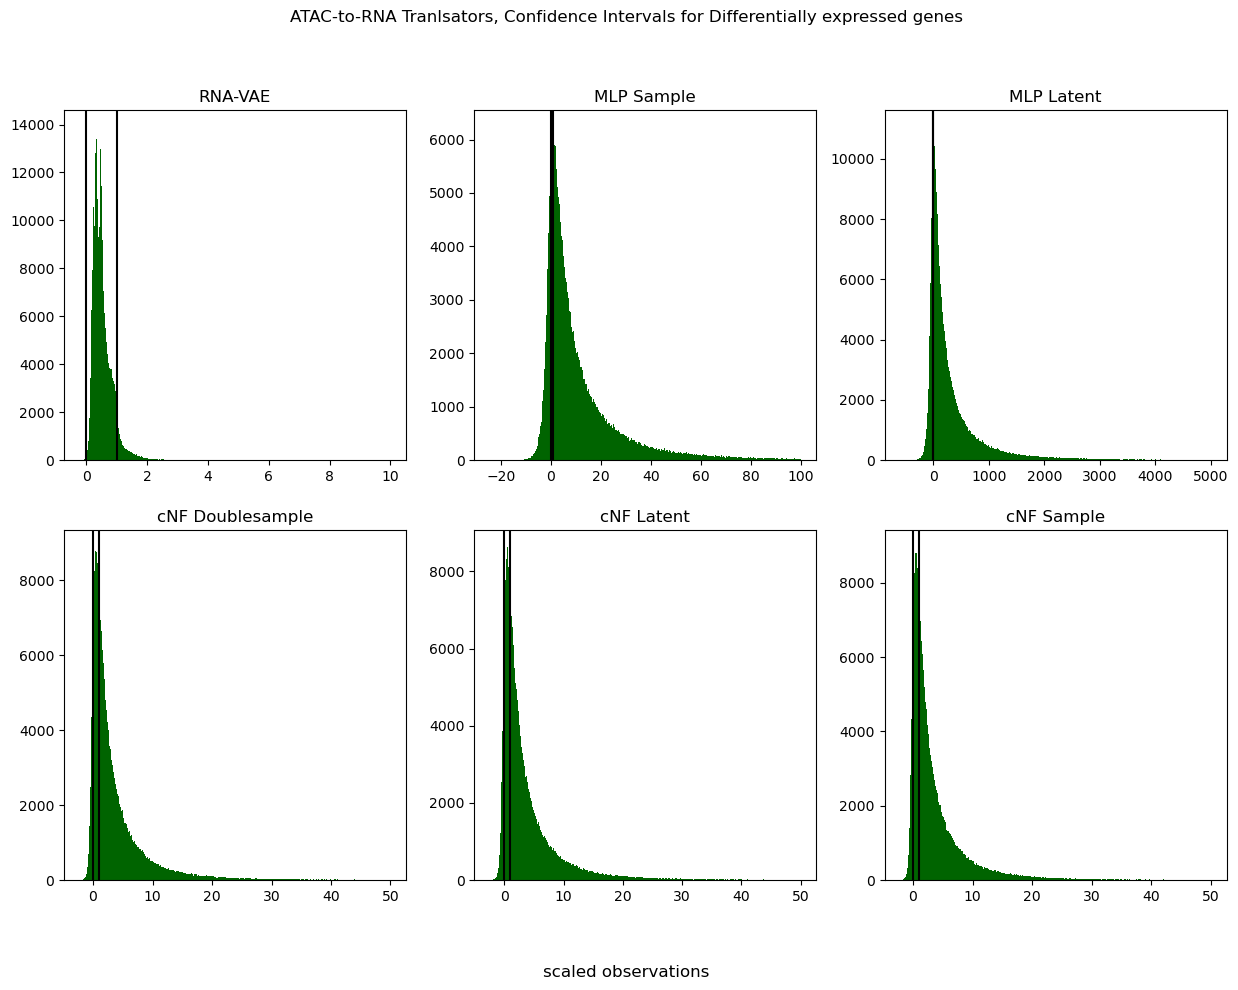

In [12]:
model_names = ["RNA-VAE", "MLP Sample", "MLP Latent", 
               "cNF Doublesample", "cNF Latent", "cNF Sample"]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i, name in enumerate(plot_df.keys()):
    row, col = i // 3, i % 3
    ax = axes[row, col]
    ax.hist(plot_df[name], bins=1000, color="darkgreen")
    ax.axvline(1, color="black")
    ax.axvline(0, color="black")
    ax.set_title(f"{model_names[i]}")
fig.supxlabel("scaled observations")
fig.suptitle("ATAC-to-RNA Tranlsators, Confidence Intervals for Differentially expressed genes")
fig.savefig(os.path.join(save_fig, "atac2rna_translators_ci.pdf"))

## RNAVAE

/data/mikulik/PolarbearPlus/notebooks/analysis_utils.py:186: RuntimeWarning: divide by zero encountered in divide
  obs_scale = (counts[condition] - q025[condition]) / (q975[condition] - q025[condition])


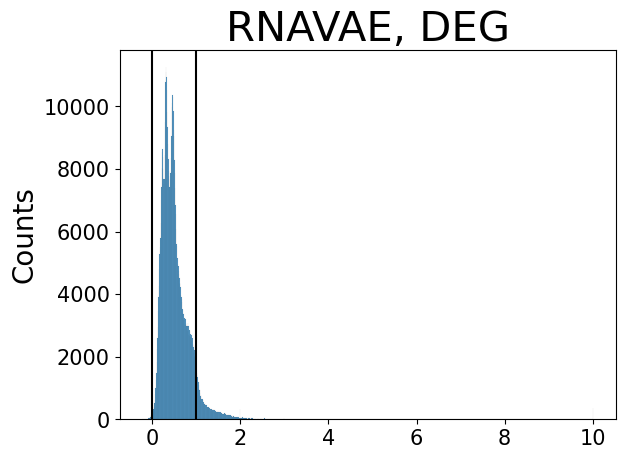

In [13]:
q025, q975 = read_vae_quantiles(data_dir="/data/mikulik/mnt_polarbear_exp/", vae="rnavae")
obs_scale = scale_quantiles(obs_rna[:, diff_genes_ind], 
                            q025[:, diff_genes_ind], 
                            q975[:, diff_genes_ind])
plot_ci(np.clip(obs_scale.reshape(-1),-1, 10), title="RNAVAE, DEG")
plot_df["RNAVAE"] = np.clip(obs_scale.reshape(-1),-1, 10).tolist()

In [14]:
ind_arr = get_index_array(obs_rna)
ind_arr = ind_arr[:, diff_genes_ind]
rna_diff = obs_rna[:, diff_genes_ind]
ind_arr = ind_arr[rna_diff > 0]


In [15]:
explore = ind_arr[obs_scale > 10]
print(explore.shape)
#print(len(explore))
explore = index_1d_to_2d(explore, width=obs_norm.shape[1])
explore[0].shape, explore[1].shape


(372,)


((372,), (372,))

In [16]:
explore[0]

array([   0,    1,    3,   10,   15,   23,   24,   26,   29,   35,   38,
         49,   51,   54,   54,   55,   58,   61,   68,   72,   72,   78,
         85,   87,   96,  103,  113,  118,  122,  122,  144,  158,  164,
        167,  172,  179,  195,  197,  205,  208,  212,  217,  219,  221,
        223,  223,  223,  229,  240,  241,  243,  243,  257,  264,  288,
        288,  291,  291,  294,  296,  296,  298,  305,  312,  313,  315,
        316,  317,  325,  327,  327,  327,  328,  343,  356,  357,  368,
        388,  388,  388,  388,  388,  388,  388,  388,  401,  401,  411,
        411,  415,  424,  428,  441,  444,  444,  447,  457,  458,  484,
        489,  489,  495,  498,  499,  505,  508,  513,  513,  518,  520,
        542,  545,  555,  558,  571,  573,  576,  576,  579,  579,  580,
        581,  600,  607,  608,  626,  628,  641,  649,  650,  651,  653,
        662,  689,  689,  700,  702,  706,  715,  720,  733,  733,  733,
        743,  753,  763,  771,  775,  776,  776,  7

In [17]:
test_cell_names.iloc[[54, 54]]

,Batch,Barcode,Ident
09E_ATGCATCCTCCA,09E,ATGCATCCTCCA,Mis
09E_ATGCATCCTCCA,09E,ATGCATCCTCCA,Mis


In [18]:
a = test_cell_names.iloc[explore[0]]
a

,Batch,Barcode,Ident
09I_CCTACATCGGAA,09I,CCTACATCGGAA,OliM
09C_CCATCCGACCCT,09C,CCATCCGACCCT,Mis
09L_GTCAACGATGCA,09L,GTCAACGATGCA,E3Rorb
09K_TCTTGTCACCTC,09K,TCTTGTCACCTC,E4Thsd7a
09B_GCGTTTCCATGT,09B,GCGTTTCCATGT,E5Galnt14
...,...,...,...
09F_GATACGCTACCG,09F,GATACGCTACCG,Mis
09J_TATGTCCACCTT,09J,TATGTCCACCTT,E2Rasgrf2
09E_CTTGTTTACTCG,09E,CTTGTTTACTCG,OliM
09E_CTTGTTTACTCG,09E,CTTGTTTACTCG,OliM


<Axes: xlabel='count', ylabel='Ident'>

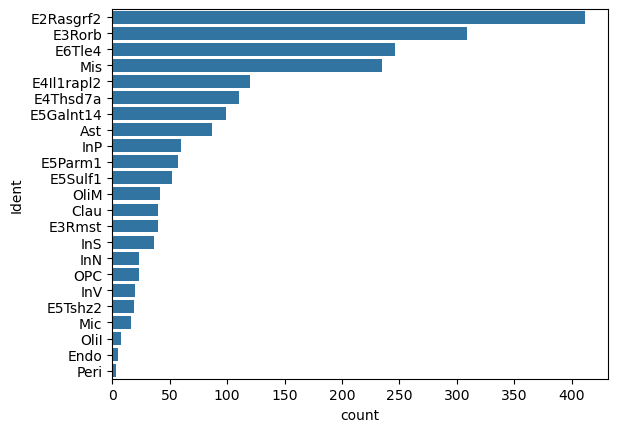

In [19]:
sns.barplot(test_cell_names.value_counts("Ident").reset_index("Ident"), y="Ident", x="count")

<Axes: xlabel='count', ylabel='Ident'>

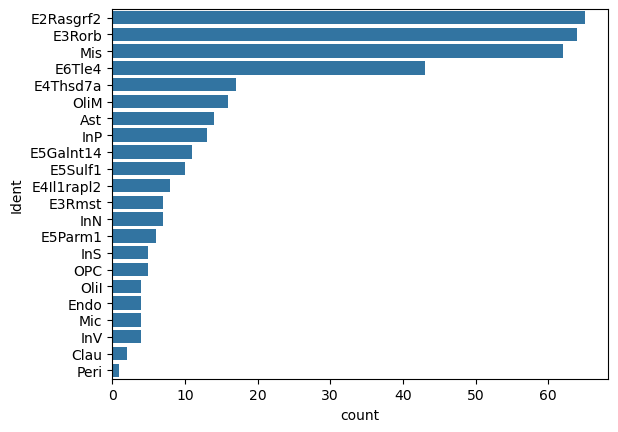

In [20]:
sns.barplot(a.value_counts("Ident").reset_index("Ident"), y="Ident", x="count")

In [21]:
a.value_counts("Ident")

Ident
E2Rasgrf2     65
E3Rorb        64
Mis           62
E6Tle4        43
E4Thsd7a      17
OliM          16
Ast           14
InP           13
E5Galnt14     11
E5Sulf1       10
E4Il1rapl2     8
E3Rmst         7
InN            7
E5Parm1        6
InS            5
OPC            5
OliI           4
Endo           4
Mic            4
InV            4
Clau           2
Peri           1
Name: count, dtype: int64

In [22]:
explore_genes = gene_names[gene_names.ind.isin(explore[1])].ind.tolist()
print(diff_genes[diff_genes.Gene.isin(gene_names[gene_names.ind.isin(explore_genes)].gene)].Gene.nunique())
gene_names[gene_names.ind.isin(explore_genes)]

138


,gene,ind
83,Pip5k1b,83
284,Egfr,284
326,Vip,326
436,Arhgap31,436
437,Gad1,437
...,...,...
16024,Mog,16024
16498,Phkg1,16498
16633,Ccp110,16633
16686,Nxph1,16686


In [23]:
tmp_df = diff_genes[diff_genes.Gene.isin(gene_names[gene_names.ind.isin(explore_genes)].gene)].drop_duplicates(subset="Gene", keep="first")

In [24]:
tmp_df.Cluster.value_counts()

Cluster
Ast                 24
Oli-Itpr2           16
Mic                 12
Oli-Mal             12
In-Pvalb            12
In-Npy               8
In-Sst               6
Claustrum            6
Ex-L5/6-Tshz2        5
OPC                  5
Peri                 5
Ex-L5-Parm1          5
In-Vip               4
Ex-L4/5-Thsd7a       4
Ex-L2/3-Rasgrf2      3
Ex-L3/4-Rorb         2
Ex-L5/6-Sulf1        2
Ex-L4/5-Il1rapl2     2
Endo                 2
Ex-L3/4-Rmst         1
Ex-L5-Galnt14        1
Ex-L6-Tle4           1
Name: count, dtype: int64

<Axes: xlabel='Fold Change (log)', ylabel='Count'>

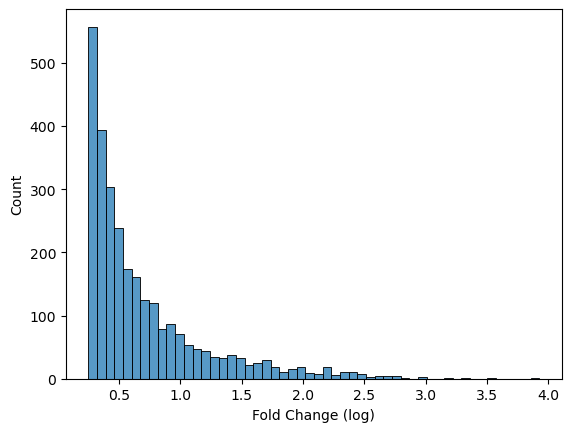

In [25]:
sns.histplot(diff_genes["Fold Change (log)"])

<Axes: xlabel='Fold Change (log)', ylabel='Count'>

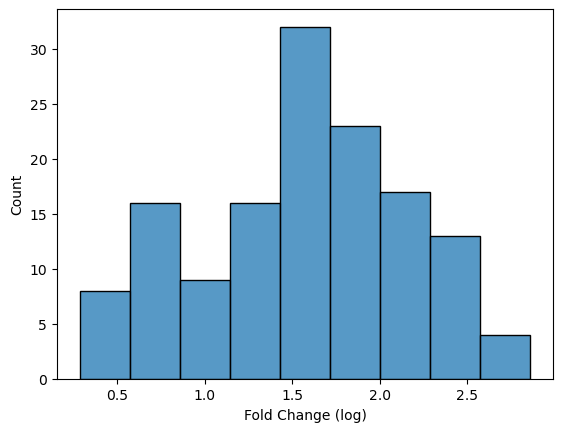

In [26]:
sns.histplot(tmp_df["Fold Change (log)"])

In [27]:
rand_ind = np.random.randint(low=0, high=obs_rna.shape[1], size=200)

<Axes: ylabel='Count'>

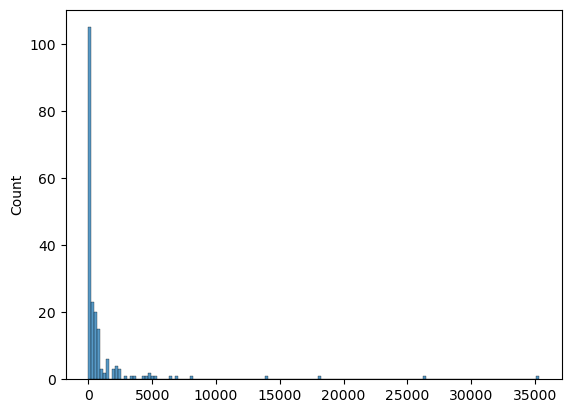

In [28]:
sns.histplot(rna_counts[:, rand_ind].sum(axis=0))

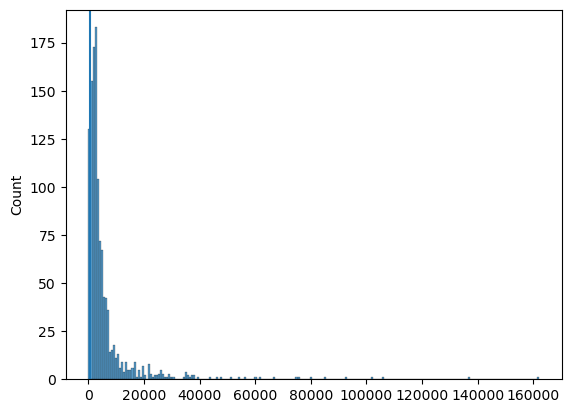

In [29]:
sns.histplot(rna_counts[:, diff_genes_ind].sum(axis=0))
plt.axvline(500)

<Axes: ylabel='Count'>

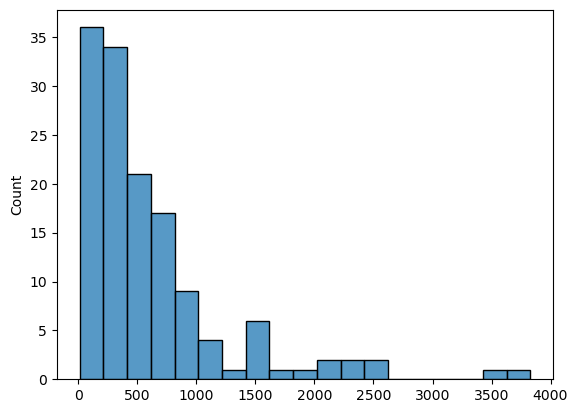

In [30]:
sns.histplot(rna_counts[:, explore_genes].sum(axis=0))

<Axes: >

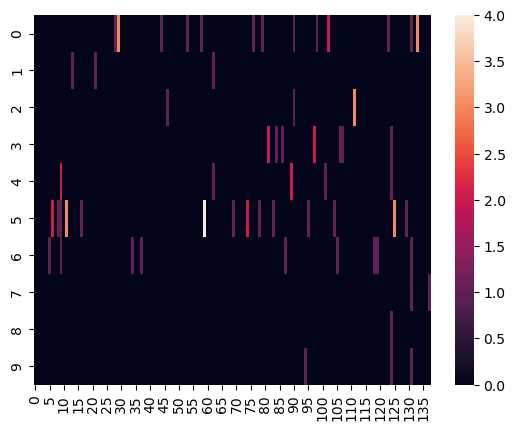

In [31]:
sns.heatmap(obs_rna[:10, explore_genes])

In [32]:
test = gene_names[gene_names.ind.isin(explore_genes)].gene

In [33]:
diff_genes[diff_genes.Gene.isin(test)]

,Gene,Fold Change (log),Percentage (in group),Percentage (out),p-value,Cluster
15,Htr1f,0.940115,0.476,0.181,1.060843e-140,Ex-L6-Tle4
157,Pamr1,0.682293,0.264,0.101,5.681586e-73,Ex-L3/4-Rorb
203,Lin7a,0.464955,0.336,0.241,1.727892e-21,Ex-L3/4-Rorb
237,Calb1,0.763950,0.287,0.062,4.649219e-194,Ex-L2/3-Rasgrf2
248,Lamp5,0.688850,0.323,0.109,3.699791e-137,Ex-L2/3-Rasgrf2
...,...,...,...,...,...,...
2799,Myl3,1.656771,0.316,0.000,0.000000e+00,Peri
2800,Gja4,1.611341,0.316,0.000,0.000000e+00,Peri
2801,Rab15,1.295439,0.368,0.086,2.807999e-06,Peri
2804,Glp2r,0.815523,0.263,0.056,5.546110e-05,Peri
